We will considered the Bayesian regression model with known variance and gaussian isotropic prior that is studied in the paper. In this code one can generate the three different estimators for a given number of observations and a given number of covariates. The model, being conjugate, allows us to also calculate the correct values for the _leave-one-out_ predictive densities. The estimators, and also the code for the functions _predictive_i, probs_i, probs_ might seem cumbersome, but are written in such a form to allow one to go to high values of values of _p_ without encountering numerical overflows. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.stats import multivariate_normal
import sys
sys.path.insert(1, "./PSIS/py")
#import gaussian_model as gm
from models import Gaussian_Model as gm
import models
import psis

## Let us simulate the data

In [2]:
n = 100; p = 50;
c =10; var_model=1;

sigma_0= c/p * np.identity(p+1)
theta_0=np.zeros((p+1,1))
#model = gm.Model(theta_0, sigma_0, var_model)
x1=np.ones((n,1))
x2=np.random.randn(n,p)
X=np.concatenate([x1,x2],axis=1)
theta=multivariate_normal(mean=theta_0.reshape(p+1),cov=sigma_0).rvs()
y=multivariate_normal(mean=np.dot(X,theta), cov=var_model*np.identity(n)).rvs()
model = gm(y, X, theta_0, sigma_0, var_model)

## Let us generate the __iid__ samples from the posterior and the mixture

In [7]:
full = model.log_p_full()
leave_one_outs_p = np.array([full-model.log_predictive_i(index) for index in range(n)])

minimum = leave_one_outs_p.min()
normalizer = np.sum(np.exp(leave_one_outs_p-minimum))
weights = np.exp(leave_one_outs_p-minimum)/normalizer

iterations=2000

###################################################
## Samples of Mixture
res=np.random.multinomial(iterations,weights)
X_js = [np.concatenate([X[0:index], X[index+1:]]) for index in range(n)]
Y_js = [np.concatenate([y[0:index], y[index+1:]]) for index in range(n)]

loos = [models.Gaussian_Model(Y_js[index], X_js[index], theta_0, sigma_0, var_model).cond_theta() for index in range(n)]
thetas_mixture=np.zeros((X.shape[1],iterations))
index=0
for j in range(n):
    if res[j] > 0:
        if res[j] == 1:
            thetas_mixture[::, index]=(loos[j].rvs(size=res[j]).transpose())
            index+=res[j]
        else:
            thetas_mixture[::, index:index+res[j]]=(loos[j].rvs(size=res[j]).transpose())
            index+=res[j]
            
posterior=model.cond_theta()
thetas_posterior=posterior.rvs(size=iterations).transpose()

## Let us create the estimators

In [5]:
is_estimators = models.Is_estimators(model)


correct_values = np.array([model.log_predictive_i(k) for k in range(n)])
lppd_posterior = is_estimators.posterior(thetas_posterior)
lppd_mixture = is_estimators.mixture(thetas_mixture)
lppd_psis = is_estimators.PSIS(thetas_posterior)

## Let us now plot to assess the accuracy of the estimated values.

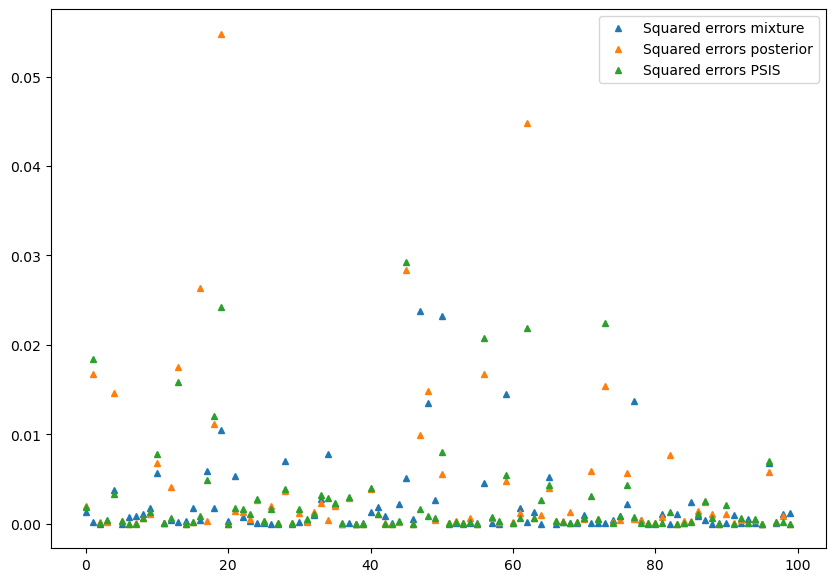

In [6]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot((correct_values-lppd_mixture)**2, linestyle="", marker="^", markersize=5, label="Squared errors mixture")
ax.plot((correct_values-lppd_posterior)**2, linestyle="", marker="^", markersize=5, label="Squared errors posterior")
ax.plot((correct_values-lppd_psis)**2, linestyle="", marker="^", markersize=5, label="Squared errors PSIS")
ax.legend()